In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import seaborn as sns
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import sklearn
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd


TYPE = "P_CLAHE_image_Xception"
PATH = os.path.join('/content/drive/MyDrive/Senior Project/Senior V 4 Grayscale/P_CLAHE/')
output_dir = '/content/drive/MyDrive/Senior Project/Senior V 4 Grayscale/P_CLAHE/Output_Xception/'+TYPE
train_dir = os.path.join(PATH, 'split_train_new_cell_png/')
# output_dir = './Output/split_'+TYPE
# train_dir = os.path.join(PATH, 'split_train')
#output_dir = './Output_Xception/'+TYPE
#train_dir = os.path.join(PATH, 'train_cell')
train_cem_dir = os.path.join(train_dir, 'ce')
train_fib_dir = os.path.join(train_dir, 'fi')
train_oss_dir = os.path.join(train_dir, 'os')

# val_dir = os.path.join(PATH, 'val')
# val_cem_dir = os.path.join(val_dir, 'Cemento')
# val_fib_dir = os.path.join(val_dir, 'Fibrous')
# val_oss_dir = os.path.join(val_dir, 'Ossifying')


BATCH_SIZE = 64
EPOCHS = 200
IMG_HEIGHT = 256
IMG_WIDTH = 256
LEARNING_RATE = 0.001
NUM_CLASS = 3

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="training",
  seed=1,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="validation",
  seed=1,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)


for images, labels in val_ds.take(1):
    x_val = images
    y_val = labels
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
#augmentation = tf.keras.Sequential([
augment_layer = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
augment_layer2 =  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
augment_layer3 =  tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.05), # horizontal stretch
augment_layer4 =  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),
augment_layer5 =  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.05, width_factor=0.05)


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


model_Xception = tf.keras.applications.Xception(
    include_top=True,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    weights= None,
    classes=NUM_CLASS,
    classifier_activation='softmax'
)
model_Xception.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
best_model = ModelCheckpoint(output_dir+'/Xception_P_CLAHE_best.h5', save_best_only=True, monitor='val_loss', mode='min')


model_Xception.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=best_model
)


Found 2528 files belonging to 3 classes.
Using 2276 files for training.
Found 2528 files belonging to 3 classes.
Using 252 files for validation.
Epoch 1/200
36/36 [==============================] - 149s 3s/step - loss: 0.7665 - accuracy: 0.7438 - val_loss: 1.0969 - val_accuracy: 0.5516
Epoch 2/200
36/36 [==============================] - 7s 193ms/step - loss: 0.4785 - accuracy: 0.8124 - val_loss: 1.0795 - val_accuracy: 0.5516
Epoch 3/200
36/36 [==============================] - 7s 194ms/step - loss: 0.3508 - accuracy: 0.8620 - val_loss: 1.0581 - val_accuracy: 0.5516
Epoch 4/200
36/36 [==============================] - 7s 193ms/step - loss: 0.2612 - accuracy: 0.9020 - val_loss: 1.0208 - val_accuracy: 0.5516
Epoch 5/200
36/36 [==============================] - 7s 195ms/step - loss: 0.1983 - accuracy: 0.9262 - val_loss: 1.0076 - val_accuracy: 0.5516
Epoch 6/200
36/36 [==============================] - 6s 162ms/step - loss: 0.1986 - accuracy: 0.9244 - val_loss: 1.0400 - val_accuracy: 0.551

### Matrix

In [ ]:
classes=['Cem','Fis','Oss']
y_pred = model_Xception.predict(x_val)
y_pred = tf.argmax(y_pred, axis=1)
con_mat = tf.math.confusion_matrix(labels=y_val, predictions=y_pred).numpy()


1/1 [==============================] - 1s 531ms/step


In [ ]:
#con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat,
                     index = classes,
                     columns = classes)

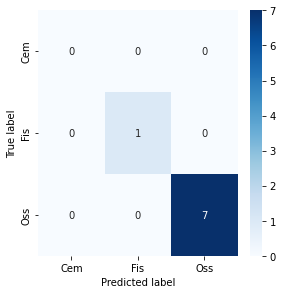

In [ ]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
figure.savefig('./output_Xception/CLAHE_image_Xception/cell_confusion_matrix.jpg')